In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from lib.Stream import Stream
from lib.Graph import Graph, StarSat, BHACore
import networkx as nx
import matplotlib.pyplot as plt
import logging

nx.__version__

'2.4'

In [5]:
s = Stream()
s.readStream("./tests/3links-StSa-dupl.json")
s.T

{'alpha': 0, 'omega': 10}

In [6]:
g3 = Graph(nx.DiGraph([(1,4), (1,5), (1,6), (2,4), (2,5), (2,6), (3,6)]), lang_left=set("abcd"), lang_right=set("wxyz"))
attr = {1: set("abc"), 2: set("abd"), 3: set("abc"), 4: set("wxy"), 5:set("wxz"), 6: set("wxy") }

nx.set_node_attributes(g3, attr, "lang")
_top = set([1,2,3])
_bot = set([4,5,6])
g3.interior(_top, _bot)

({1, 2}, {4, 5, 6})

In [9]:
I = ([g3.nodes[x]["lang"] for x in _top], [g3.nodes[x]["lang"] for x in _bot])
I = (set("abcd"), set("wxyz"))
q = g3._int([g3.nodes[x]["lang"] for x in _top], [g3.nodes[x]["lang"] for x in _bot])
g3.bipatterns(_top, _bot)

({'a', 'b'}, {'w', 'x'}) ({1, 2}, {4, 5, 6}) 0
({'a', 'b'}, {'w', 'y', 'x'}) ({1, 2}, {4, 6}) 1
({'c', 'a', 'b'}, {'w', 'y', 'x'}) ({1}, {4, 6}) 2
({'a', 'b'}, set()) ({1, 2}, set()) 2
({'d', 'a', 'b'}, {'w', 'y', 'x'}) ({2}, {4, 6}) 2
({'c', 'a', 'b'}, {'w', 'x'}) ({1}, {4, 5, 6}) 1
({'a', 'b'}, {'w', 'z', 'x'}) ({1, 2}, {5}) 1
({'d', 'a', 'b'}, {'w', 'x'}) ({2}, {4, 5, 6}) 1


In [10]:
g = Graph(nx.Graph([(1,2), (1,3), (2,3), (3,4), (4,5)]))
attr = {i: set() for i in g.nodes() }
nx.set_node_attributes(g, attr, "lang")

g2 = Graph(nx.Graph([(1,2), (1,3), (2,3), (3,4), (4,5), (4,6), (4,7)]))
attr = {i: set() for i in g2.nodes() }
nx.set_node_attributes(g2, attr, "lang")

print(g.interior(set(g.nodes()), set(g.nodes())))
print(g2.interior(set(g2.nodes()), set(g2.nodes())))

({1, 2, 3}, {1, 2, 3})
({1, 2, 3}, {1, 2, 3})


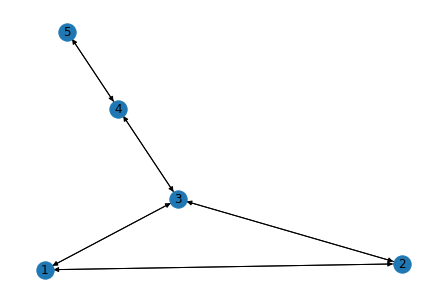

In [11]:
nx.draw(g, with_labels=True)

In [12]:
g.interior(set(g.nodes()), set(g.nodes()))

({1, 2, 3}, {1, 2, 3})

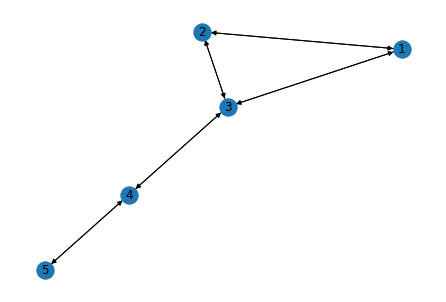

In [13]:
nx.draw(g, with_labels=True)

In [14]:
g2.interior(set(g2.nodes()), set(g2.nodes()))

({1, 2, 3}, {1, 2, 3})

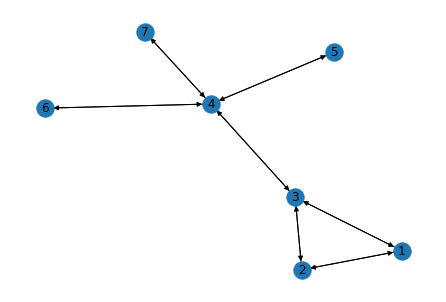

In [15]:
nx.draw(g2, with_labels=True)

Faire des minidonnées de test, calculer l'intérieur (pour des propriétés de degrés genre hub-autorité etc.)

Pareil pour le pattern enumeration

In [8]:
X1 = [(x["u"], (x["b"], x["e"])) for x in s.E ]
X2 = [(x["v"], (x["b"], x["e"])) for x in s.E ]

X = X1 + X2

def intersect(i, j):
    # returns the intersection of two time intervals, or -1 is it is void
    # does not make any asumption obout the order of the intervals, however
    # both i and j *are* intervals (i.e. e >= b, and f >= c)
    # TODO: extend to list of intervals
    b, e = i
    c, f = j
    
    # Disjoint
    if c >= e or f <= b:
        return -1
    # Inclusion
    if (c >= b and f <= e) or \
       (b >= c and e <= f):
            return (max(b,c), min(e,f))
    
    # intersection
    if (c <= b and f >= b and f <= e) or\
       (b <= c and e >= c and e <= f):
        return (max(b,c), min(e,f))
    
    return 0

def reduce(s, x, Z1, Z2):
    v = x[0]
    (b, e) = x[1]
    deg_filter = [i for i in s.degrees[v] if intersect(i[1], x[1]) != -1 ]
    print(deg_filter)
    return False

def p2(x, Z1, Z2):
    return True

# def interior(X1, X2):
#         # X1, X2: ensembles de tuples {u}x[b,e]
#         S1 = X1
#         S2 = X2

#         Z1 = S1
#         Z2 = S2

#         while 1:
#             Z1 = S1.copy()
#             Z2 = S2.copy()

#             for x in Z1:
#                 res = reduce(s, x, Z1, Z2)
#                 S1.remove(x)

#             for x in Z2:
#                 if not p2(x, Z1, Z2):
#                     S2.remove(x)

#             if S1 == Z1 or S2 == Z2:
#                 break 

#         return S1, S2

In [43]:
def prop_degree(u):
    from operator import itemgetter
    result = []
    times = s.degrees[u]
    sorted_times = sorted(times, key=itemgetter(1))

    prop_true_t = 0
    deg = 0
    prop_was_true = False

    for v, t, ev_type in sorted_times:
        prop_is_true = False
        if ev_type == 1:
            deg += 1
        elif ev_type == -1:
            deg -= 1

        if deg >= 3:
            if not prop_was_true:
                prop_true_t = t
            prop_is_true = True
            prop_was_true = True

        if not prop_is_true and prop_was_true:
            result.append((u, prop_true_t, t))
            prop_was_true = False
            
    if len(result) > 0:
        return True, result
    else:
        return False, result
    
def prop_degree_2(u):
    from operator import itemgetter
    result = []

    for x in s.neighbours(u):
        times = s.degrees[x]
        sorted_times = sorted(times, key=itemgetter(1))

        prop_true_t = 0
        deg = 0
        prop_was_true = False

        for v, t, ev_type in sorted_times:
            prop_is_true = False
            if ev_type == 1:
                deg += 1
            elif ev_type == -1:
                deg -= 1

            if deg >= 3:
                if not prop_was_true:
                    prop_true_t = t
                prop_is_true = True
                prop_was_true = True

            if not prop_is_true and prop_was_true:
                result.append((x, prop_true_t, t))
                prop_was_true = False
    return True, result
    
def interior(s, X):
    result = []
    p2 = []
    
    for u in s.degrees:
        _, tmp = prop_degree(u)
        __, tmp2 = prop_2(u)
        
        if _ :
            result += tmp
        if __ :
            p2 += tmp2

    return result, p2

print(interior(s, X))

([('v', 2, 4)], [('y', 2, 4), ('u', 2, 4), ('x', 2, 4)])


In [44]:
intersect((2,3), (5,6)), intersect((2,3), (2,3)), intersect((1,6), (2,3)), intersect((1,5), (2,6)), intersect((2,6), (1,5))

(-1, (2, 3), (2, 3), (2, 5), (2, 5))

In [5]:
q = set(['a', 'b', 'c'])
EL = set(['a'])
q.intersection(EL)

{'a'}